In [15]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from Graph import *
from Azimuth import *
from math import sqrt

import seaborn as sns
import numpy as np



## Test the Graph class

In [2]:
vertex1 = Vertex(60, 2, 0)
vertex2 = Vertex(61, 3, 0)

edge = Edge([vertex1, vertex2])

print(edge.angle, edge.length, edge.intermediate_point())

346.10049260270813 123941.99560434723 (-0.8514343297185806, -0.9452436335558858)


In [3]:
graph = Graph(warnings = True)

last_vertex = Vertex(-1, -1, 0, warnings = True)
graph.add_vertices(last_vertex)

for i in range(0,10):
    new_vertex = Vertex(i, i, 0, warnings = True)
    edge = Edge(vertices = [last_vertex, new_vertex], warnings = True)
    graph.add_vertices(new_vertex)
    last_vertex = new_vertex

In [4]:
pp.pprint(graph.vertices)
pp.pprint(graph.edges)
    
for i in range(5):
    cur_vertex = next(iter(graph.vertices))
    cur_vertex.set_graph(None)

    pp.pprint(graph.vertices)
    pp.pprint(graph.edges)
    pp.pprint("")

{   <Vertex: -1,-1,0>,
    <Vertex: 0,0,0>,
    <Vertex: 1,1,0>,
    <Vertex: 2,2,0>,
    <Vertex: 3,3,0>,
    <Vertex: 4,4,0>,
    <Vertex: 5,5,0>,
    <Vertex: 6,6,0>,
    <Vertex: 7,7,0>,
    <Vertex: 8,8,0>,
    <Vertex: 9,9,0>}
{   <Edge: (<Vertex: 0,0,0>) -> (<Vertex: 1,1,0>)>,
    <Edge: (<Vertex: -1,-1,0>) -> (<Vertex: 0,0,0>)>,
    <Edge: (<Vertex: 1,1,0>) -> (<Vertex: 2,2,0>)>,
    <Edge: (<Vertex: 2,2,0>) -> (<Vertex: 3,3,0>)>,
    <Edge: (<Vertex: 3,3,0>) -> (<Vertex: 4,4,0>)>,
    <Edge: (<Vertex: 4,4,0>) -> (<Vertex: 5,5,0>)>,
    <Edge: (<Vertex: 5,5,0>) -> (<Vertex: 6,6,0>)>,
    <Edge: (<Vertex: 6,6,0>) -> (<Vertex: 7,7,0>)>,
    <Edge: (<Vertex: 7,7,0>) -> (<Vertex: 8,8,0>)>,
    <Edge: (<Vertex: 8,8,0>) -> (<Vertex: 9,9,0>)>}
{   <Vertex: 0,0,0>,
    <Vertex: 1,1,0>,
    <Vertex: 2,2,0>,
    <Vertex: 3,3,0>,
    <Vertex: 4,4,0>,
    <Vertex: 5,5,0>,
    <Vertex: 6,6,0>,
    <Vertex: 7,7,0>,
    <Vertex: 8,8,0>,
    <Vertex: 9,9,0>}
{   <Edge: (<Vertex: 0,0,0>) -> (<V

In [5]:
print(calculate_angle(60, 61, 2, 3))
print(calculate_angle(60, 61, 3, 2))

346.10049260270813
13.89950739729187


## Angle graphifying

In [6]:
df = pd.read_csv("presets/0.csv")

In [7]:
tra = df["trajectory"].unique()[0]
dft = df[df["trajectory"] == tra]

In [ ]:
# Additional idea: combine edges with similar angles
# For report we attempt to model the topology of a city (vertices, edges and planes) of a city from geographical data

### Testing division

In [ ]:
# divide latitude by 69 and longitude by 52

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


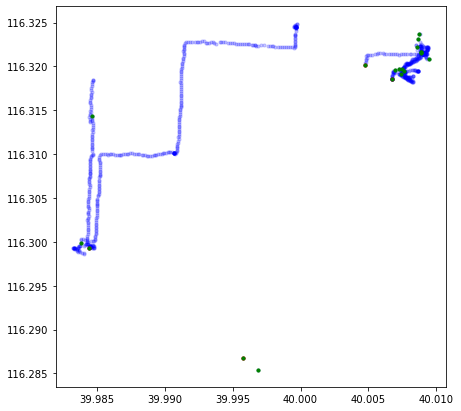

In [8]:
dft.loc[:, "latitude_change"] = dft.loc[:,"latitude"] - dft.loc[:,"latitude"].shift(1)
dft.loc[:, "longitude_change"] = dft.loc[:,"longitude"] - dft.loc[:,"longitude"].shift(1)

def pythago(lat, long):
    return sqrt(lat*lat + long*long)

dft.loc[:,["change"]] = dft.apply(lambda x: pythago(x.latitude_change, x.longitude_change), axis=1)

maximum = dft.loc[:,"change"].mean()*10
fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(dft.latitude, dft.longitude, zorder=1, alpha= 0.2, c='b', s=10)

df1 = dft[dft["change"] > dft["change"].mean()*10]
ax.scatter(df1.latitude, df1.longitude, zorder=1, alpha=1, c='r', s=10)

q25 = dft["change"].quantile(0.25)
q75 = dft["change"].quantile(0.75)
df2 = dft[dft["change"] > (q75 + 1.5*(q75 + q25))]
ax.scatter(df2.latitude, df2.longitude, zorder=1, alpha=1, c='g', s=10)

### The actual graph

reduced from 907 to 413 points


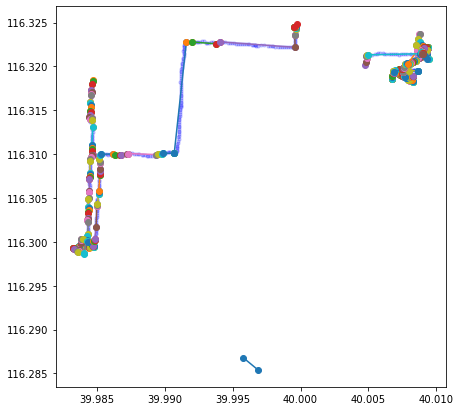

In [16]:
graph = create_azimuth_graph(dft, method = 4, splitting_method = 2, distance_multiplier = 5, max_angle_change = 15)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(dft.latitude, dft.longitude, zorder=1, alpha= 0.2, c='b', s=10)

for edge in graph.edges:
    lat1 = min(edge.vertices).latitude
    long1 = min(edge.vertices).longitude
    
    lat2 = max(edge.vertices).latitude
    long2 = max(edge.vertices).longitude
    
    plt.plot([lat1, lat2], [long1, long2], marker = 'o')

star_vertices = [vertex for vertex in graph.vertices if len(vertex.edges) == 1]
for vertex in star_vertices:
    ax.plot(vertex.latitude, vertex.longitude, markersize=50)
    
ax = plt.gca()
#ax.set_xlim([40.0035, 40.0115])
#ax.set_ylim([116.3175, 116.3245])
print(f"reduced from {len(dft)} to {len(graph.vertices)} points")

In [ ]:
# change gaps into different trajectory
# add distance to angle calculation